In [1]:
#importing useful python libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
# Sklearn tools
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix,ConfusionMatrixDisplay
#from sklearn.model_selection import cross_val_score

# XGBoost
from xgboost import XGBClassifier

In [2]:
#load data set
df= pd.read_parquet("subset of baseline with samples 50neg & pos.parquet")

In [3]:
df.keys()

Index(['object', 'mean', 'weighted_mean', 'standard_deviation', 'median',
       'amplitude', 'beyond_1_std', 'cusum', 'inter_percentile_range_10',
       'kurtosis', 'linear_trend', 'linear_trend_sigma', 'linear_trend_noise',
       'linear_fit_slope', 'linear_fit_slope_sigma', 'linear_fit_reduced_chi2',
       'magnitude_percentage_ratio_40_5', 'magnitude_percentage_ratio_20_10',
       'maximum_slope', 'median_absolute_deviation',
       'median_buffer_range_percentage_10', 'percent_amplitude',
       'mean_variance', 'anderson_darling_normal', 'chi2', 'skew', 'stetson_K',
       'cluster', 'cluster_id'],
      dtype='object')

In [4]:
#X
X = df.drop(columns=['object','cluster', 'cluster_id']).values

In [5]:
# object column contains names like 'ZTF18abc...' or non-ZTF names : Binary conversion of objects
y = np.where(df['object'].str.contains('ZTF', case=False),
             -1,   # ZTF → negative
              1)   # non-ZTF → positive

In [6]:
print(np.unique(y))


[-1  1]


In [7]:
#doing this as XGBBOOST can't deal with -1 and 1
y[y == -1] = 0


In [8]:
print(np.unique(y))


[0 1]


In [9]:
#run accuracy
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.20,
)

In [10]:
#model fit
xgb_model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1, #Learning rate shrinks the contribution of each tree,Values must be in the range [0.0, inf),values by default float, default=0.1
    max_depth=3, #max_depthint or None, default=3
    #random_state=42,
    eval_metric='logloss' #The loss function to be optimized. ‘log_loss’ refers to binomial and multinomial deviance, the same as used in logistic regression. 
)


In [11]:
#training set
xgb_model.fit(X_train, y_train)

print("Model trained successfully")


Model trained successfully


In [12]:
#predict model
y_pred = xgb_model.predict(X_test)
print(y_pred)


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 1 0 1 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0]


In [13]:
#accuracy
print("Accuracy:", accuracy_score(y_test, y_pred))


Accuracy: 0.9875


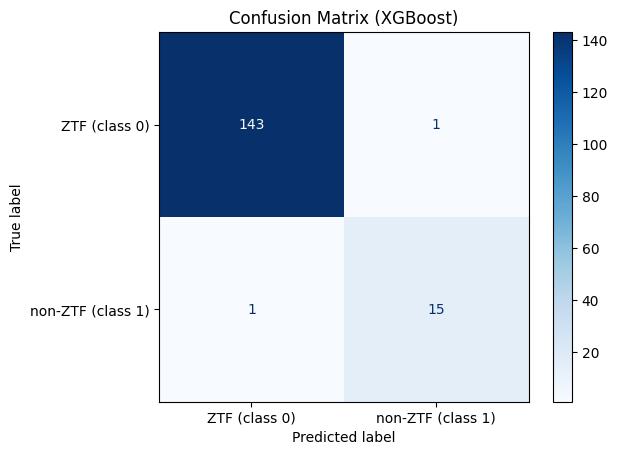

In [14]:
# --- Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])

class_names = ["ZTF (class 0)", "non-ZTF (class 1)"]

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix (XGBoost)")
plt.show()

In [15]:
#extract TP, TN, FP, FN
TN, FP, FN, TP = cm.ravel()
print("TN:", TN, "FP:", FP, "FN:", FN, "TP:", TP)

TN: 143 FP: 1 FN: 1 TP: 15


In [16]:
#choosing the best parameters
train_sizes = np.arange(0.5, 0.91, 0.1)
n_estimators_array = np.arange(50, 201, 20)

results = []

for size in train_sizes:

    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        train_size=size,
        #random_state=42,
        shuffle=True
    )

    for n in n_estimators_array:

        model = XGBClassifier(
            n_estimators=n,
            learning_rate=0.1,
            max_depth=3,
            eval_metric='logloss'
        )

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        acc = accuracy_score(y_test, y_pred)

        results.append({
            "train_size": size,
            "n_estimators": n,
            "accuracy": acc
        })

# Convert to DataFrame
results_df = pd.DataFrame(results)

# Sort by best accuracy
results_df = results_df.sort_values(by="accuracy", ascending=False)

# Show top 10 results
print(results_df.head(10))

# Best configuration
best_row = results_df.iloc[0]
print("\nBest Configuration:")
print(best_row)

    train_size  n_estimators  accuracy
20         0.7           130  0.970833
19         0.7           110  0.970833
18         0.7            90  0.970833
17         0.7            70  0.970833
16         0.7            50  0.970833
23         0.7           190  0.966667
21         0.7           150  0.966667
22         0.7           170  0.966667
8          0.6            50  0.965625
9          0.6            70  0.965625

Best Configuration:
train_size        0.700000
n_estimators    130.000000
accuracy          0.970833
Name: 20, dtype: float64


In [17]:
#saving results
results_df.to_csv("xgb_results.csv", index=False)


In [18]:
# Best hyperparameters
best_train_size = best_row["train_size"]
best_n_estimators = int(best_row["n_estimators"])

# Final train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    train_size=best_train_size,
    shuffle=True,
    #random_state=42
)

# Train final model
final_model =  XGBClassifier(
    n_estimators=best_n_estimators,
    n_jobs=-1,
)

final_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=130,
              n_jobs=-1, num_parallel_tree=None, ...)

Confusion matrix (raw counts):
[[207   1]
 [  2  30]]


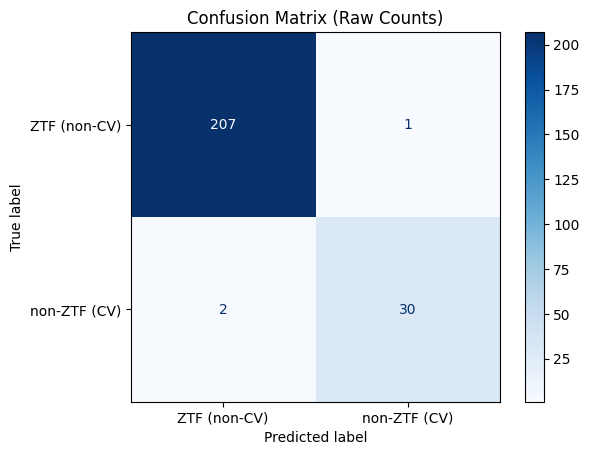

In [19]:
# CONFUSION MATRIX + TP / TN / FP / FN IDENTIFICATION
# Class labels for clarity
class_names = ["ZTF (non-CV)", "non-ZTF (CV)"]

# Plot confusion matrix (raw counts)
disp = ConfusionMatrixDisplay.from_estimator(
   final_model,
    X_test,
    y_test,
    display_labels=class_names,
    cmap=plt.cm.Blues #heatmap
)

disp.ax_.set_title("Confusion Matrix (Raw Counts)")
print("Confusion matrix (raw counts):")
print(disp.confusion_matrix)

plt.show()


# Extract TN, FP, FN, TP explicitly
# Label convention used in YOUR code:
#   0 → ZTF (negative, non-CV)
#   +1 → non-ZTF (positive, CV)

cm = confusion_matrix(y_test, final_model.predict(X_test), labels=[0, 1])

TN, FP, FN, TP = cm.ravel()

In [20]:
#saving the final model
joblib.dump(final_model, "cv_classifier_xgb_boost.pkl")

['cv_classifier_xgb_boost.pkl']

In [21]:
#loading hidden dataset to check accuracy
df=pd.read_parquet('baseline set with hidden neg and pos.parquet')

In [22]:
#stepping forward with useful numerical data only
X = df.drop(columns=['object','cluster', 'cluster_id']).values

In [23]:
# object column contains names like 'ZTF18abc...' or non-ZTF names : Binary conversion of objects
y = np.where(df['object'].str.contains('ZTF', case=False),
             0,   # ZTF → negative
              1)   # non-ZTF → positive

In [24]:
#run accuracy
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=1-best_train_size,
)

final_model =  XGBClassifier(
    n_estimators=best_n_estimators,
)

final_model.fit(X_train, y_train)

test_accuracy = final_model.score(X_test, y_test)
print("\nFinal test accuracy:", test_accuracy)


Final test accuracy: 0.9508196721311475


In [25]:


#measuring robustness through 5-fold cross-validation.
scores = cross_val_score(
    final_model,
    X,
    y,
    cv=5
)

print("Cross-validation scores:", scores)
print("Mean CV accuracy:", scores.mean())
print("Std CV accuracy:", scores.std())

Cross-validation scores: [0.98148148 0.98148148 0.96296296 0.94444444 0.9691358 ]
Mean CV accuracy: 0.9679012345679012
Std CV accuracy: 0.013747566327975387


In [26]:
# Check class probabilities for the test set.
# predict_proba returns an array of shape (N_test, 2),
# where N_test is the number of test objects.
# Column 0 → probability of class 0 (negative, ZTF)
# Column 1 → probability of class +1 (positive, non-ZTF)
probs = final_model.predict_proba(X_test)
print('probs',probs)

probs [[9.98515844e-01 1.48413086e-03]
 [9.99851227e-01 1.48790103e-04]
 [9.99397337e-01 6.02655928e-04]
 [9.99209464e-01 7.90557999e-04]
 [2.65183210e-01 7.34816790e-01]
 [9.99720931e-01 2.79066706e-04]
 [9.99803245e-01 1.96727939e-04]
 [8.97341669e-01 1.02658339e-01]
 [9.99609292e-01 3.90699395e-04]
 [9.99967635e-01 3.23462918e-05]
 [9.99887526e-01 1.12458751e-04]
 [9.97778893e-01 2.22111470e-03]
 [3.05845022e-01 6.94154978e-01]
 [9.99326348e-01 6.73637842e-04]
 [9.99119699e-01 8.80323991e-04]
 [9.99447167e-01 5.52814745e-04]
 [9.97674167e-01 2.32581771e-03]
 [9.99725163e-01 2.74850347e-04]
 [9.99952495e-01 4.74878361e-05]
 [9.99620914e-01 3.79094621e-04]
 [9.90337670e-01 9.66234691e-03]
 [9.99659717e-01 3.40289174e-04]
 [9.97980773e-01 2.01920606e-03]
 [9.87672627e-01 1.23273721e-02]
 [9.81949985e-01 1.80500317e-02]
 [9.18203592e-01 8.17964375e-02]
 [9.99544442e-01 4.55561414e-04]
 [9.99789000e-01 2.11011371e-04]
 [9.96358991e-01 3.64099815e-03]
 [9.99856532e-01 1.43491052e-04]
 [7.

In [27]:
#sanity check
#saved_model
saved_model = joblib.load("cv_classifier_xgb_boost.pkl")
#load dataset
df = pd.read_parquet("baseline set with hidden neg and pos.parquet")
#x_axis
X = df.drop(columns=['object','cluster','cluster_id']).values
#y_label
y_true = np.where(
    df["object"].str.contains("ZTF", case=False),
     0,
     1
)

In [28]:
# Predictions
y_pred = saved_model.predict(X)

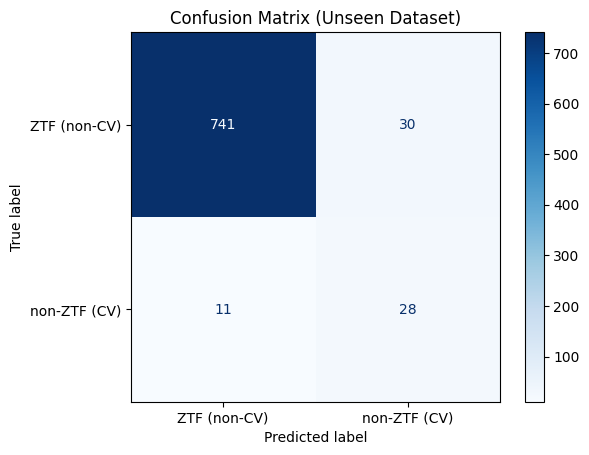

In [29]:
# Confusion matrix
class_names = ["ZTF (non-CV)", "non-ZTF (CV)"]

disp = ConfusionMatrixDisplay.from_predictions(
    y_true,
    y_pred,
    labels=[0, 1],
    display_labels=class_names,
    cmap=plt.cm.Blues
)

disp.ax_.set_title("Confusion Matrix (Unseen Dataset)")
plt.show()

In [30]:
#run through
y_true

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [31]:
#checking data
pos=(y_true==1).sum()

In [32]:
pos

39

In [33]:
neg=(y_true==0).sum()

In [34]:
neg

771

In [35]:
n_pos = (y_pred == 1).sum()

In [36]:
n_pos

58

In [37]:
n_neg=(y_pred==0).sum()

In [38]:
n_neg

752